In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from math import log
from re import compile
from urllib.parse import urlparse
from socket import gethostbyname
from pyquery import PyQuery
from requests import get
from json import dump
from string import ascii_lowercase
from numpy import array
import time


# Features Extraction :
In this code we will extract the features from URLs, and you will find all feature fonction here

## lexical features 
list of all lexical features :
    - entropy
    - url_has_port_in_string -> float
    - number_of_digits
    - number_of_parameters
    - number_of_fragments
    - is_encoded
    - number_of_dots
    - has_client_in_string
    - has_admin_in_string
    - has_server_in_string
    - has_login_in_string
    - tld
    - CharacterContinuityRate
    - domain_token_count

    - Path_Domain_ratio
    - Path_URL_ratio
    - Query_Digit_Count
    - Longest_Path_token
    - Symbol_Count_Domain
    

In [2]:

def get_entropy(URL):## ??
    URL = URL.lower()
    probs = [URL.count(c) / len(URL) for c in set(URL)]
    entropy = -sum([p * log(p) / log(2.0) for p in probs])
    return entropy

def url_has_port_in_string(URL_parsed):
    try :
        has_port = URL_parsed.netloc.split(':')
        return 1 if len(has_port) > 1 and has_port[-1].isdigit() else 0
    except :
        return 0

def number_of_digits(URL):
    try :
        digits = [i for i in URL if i.isdigit()]
        return len(digits)
    except :
        return 0

def number_of_parameters(URL_parsed):
    try :
        params = URL_parsed.query
        return 0 if params == '' else len(params.split('&'))
    except :
        return 0


def number_of_fragments(URL_parsed):
    try :
        frags = URL_parsed.fragment
        return frags.count('#') if frags != '' else 0
    except :
        return 0


def is_encoded(URL):
    try:
        return 1 if '%' in URL else 0
    except :
        return 0



def number_of_dots(URL):
    try :
        dots = [i for i in URL if i == '.'] ## ??
        return len(dots)
    except :
        return 0

def has_client_in_string(URL):
    try :
        return 1 if 'client' in URL.lower() else 0
    except :
        return 0

def has_admin_in_string(URL):
    try :
        return 1 if 'admin' in URL.lower() else 0
    except :
        return 0

def has_server_in_string(URL):
    try :
       return 1 if 'server' in URL.lower() else 0
    except :
        return 0

def has_login_in_string(URL):
    try :
         return 1 if 'login' in URL.lower() else 0
    except :
        return 0

def get_tld(URL_parsed): # https://miro.medium.com/v2/resize:fi
                                             #----
    try :
        if not url_host_is_ip(URL_parsed) :
            tld = URL_parsed.netloc.split('.')[-1].split(':')[0]
            return tld if len(tld)<10 else ''
        else: return ''
    except :
        return ''
    
def url_host_is_ip(URL_parsed):
    try :
        host = URL_parsed.netloc
        pattern = compile("^\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}$")
        match = pattern.match(host)
        return 1 if match is not None else 0
    except :
        return 0

def CharacterContinuityRate(URL_parsed):
    try :

        if not url_host_is_ip(URL_parsed):
            Domain = URL_parsed.geturl()
            counter = dict()
            counter['digit'] = 0
            counter['alpha'] = 0
            counter['symbol'] = 0
            counter_digit__ = 0
            counter_alpha__ = 0
            counter_symbol__ = 0
            was_alpha = False
            was_digit = False
            was_symbol = False
            for c in Domain :
                if c.isdigit() :
                    if was_digit :
                        counter_digit__ +=1
                    else : 
                        was_alpha, was_symbol, was_digit = False ,False, True
                        counter_digit__  = 1
                    counter['digit']= max(counter['digit'], counter_digit__)


                elif c.isalpha() :
                    if was_alpha :
                        counter_alpha__ +=1
                    else : 
                        was_digit, was_symbol, was_alpha = False ,False, True
                        counter_alpha__  = 1
                    counter['alpha']= max(counter['alpha'], counter_alpha__)
                else  :                  
                    if was_symbol : 
                        counter_symbol__ +=1
                    else : 
                        was_digit, was_alpha, was_symbol = False ,False, True
                        counter_symbol__  = 1
                    counter['symbol']= max(counter['symbol'], counter_symbol__)
            return (counter['alpha']+ counter['digit']+ counter['symbol'])/len(Domain)
        else :
            return 4/15
    except :
        return 0
    

def domain_token_count(URL):
    try:
        token_count= URL.count('/')
        return token_count
    except :
        return 0

def Path_Domain_ratio(URL_parsed):
    try :
        path_ = len(URL_parsed.path)
        domain_ = len(URL_parsed.netloc)
        return path_ / domain_
    except :
        return 0


def Path_URL_ratio(URL_parsed):
        try :
            path_ = len(URL_parsed.path)
            URL_ = len(URL_parsed.geturl())
            return path_ / URL_
        except :
            return 0


def  Query_Digit_Count(URL_parsed):# Number of digits in the query part of the URL.
    try :
        digits = [i for i in URL_parsed.query if i.isdigit()]
        return len(digits)
    except :
        return 0

def Longest_Path_token(URL_parsed):
    try :
        Path_ = URL_parsed.path
        lengths_ = list()
        counter = 0
        for c in Path_ :
            if c == '/': 
                lengths_.append(counter)
                counter = 0
            else: counter += 1

        return max(lengths_)
    except :
        return 0

def Symbol_Count_Domain(URL):  #in "://.:/?=,;()]+"
    try :
        counter = 0  
        for c in URL:
            if c in "://.:/?=,;()]+" : counter += 1
        return counter
    except :
        return 0




## Host-Based features :
list of all Host-Based features :
    - number_of_subdomains
    - url_age
    - url_intended_life_span
    - url_life_remaining
    - url_registrar
    - url_scheme
    

In [3]:
from datetime import datetime
from re import compile
from json import dump, loads
from time import sleep
import whois
from requests import get

In [4]:
def __get_ip(URL_parsed):
    try:
        ip = URL_parsed.netloc if url_host_is_ip(URL_parsed) else gethostbyname(URL_parsed.netloc)
        return ip
    except:
        return None
    
def __get__whois_dict(URL_parsed):

    try:

        IP = __get_ip(URL_parsed)
        whois_dict = whois(__get_ip(URL_parsed))
        return whois_dict
    except:
        return {}
    
def __parse__before__date(self, date_string):
    month_year = date_string.split()[-1]
    d = '01-{}'.format(month_year)
    d = datetime.strptime(d, '%d-%b-%Y')
    return d

def __parse_whois_date(self, date_key):
    cdate = self.whois.get(date_key, None)
    if cdate:
        if isinstance(cdate, str) and 'before' in cdate:
            d = self.__parse__before__date(cdate)
        elif isinstance(cdate, list):
            d = cdate[0]
        else:
            d = cdate
    if cdate :
        return d
    else :
        return cdate
    # return d if cdate else cdate
def number_of_subdomains(whois_Dict):
    try :
        ln1 = whois_Dict.get('nets', None)
        return len(ln1) if ln1 else None
    except :
        return 0
# def url_creation_date(self):
#     d = self.__parse_whois_date('creation_date')
#     return d


# def url_expiration_date(self):
#     d = self.__parse_whois_date('expiration_date')
#     return d

# def url_last_updated(self):
#     d = self.__parse_whois_date('updated_date')
#     return d

# def url_age(self):
#     try:
#         days = (self.now - self.url_creation_date()).days
#     except:
#         days = None
#     return days

# def url_intended_life_span(self):
#     try:
#         lifespan = (self.url_expiration_date() - self.url_creation_date()).days
#     except:
#         lifespan = None
#     return lifespan

# def url_life_remaining(self):
#     try:
#         rem = (self.url_expiration_date() - self.now).days
#     except:
#         rem = None
#     return rem
# ##  registrar : is the company that this domain is registered with.
# def url_registrar(self):
#     return self.whois.get('registrar', None)
	
def URL_scheme(URL_parse):
    try :
        scheme = URL_parse.scheme
        return scheme
    except :
        return ''



## Extraction Code :


In [5]:
import validators.url as url


def URLParse_with_exeption(URL):
    try :
        url_parse = urlparse(URL)
        return url_parse
    except ValueError :
        print(URL)
        return None
def validate_url(URL):
    if not url(URL):
        URL = "NoScheme://" + URL
    return URL





In [6]:
import pandas as pd

du = pd.read_csv('data.csv')

############################ lecixal features #############################################

du["entropy"] = du["url"].apply(get_entropy)
du["url_parsed"] = du["url"].apply(validate_url).apply(URLParse_with_exeption)
du["has_a_port"] = du["url_parsed"].apply(url_has_port_in_string)
du["number_of_digits"] = du["url"].apply(number_of_digits)
du["number_of_parameters"] = du["url_parsed"].apply(number_of_parameters)
du["number_of_fragments"] = du["url_parsed"].apply(number_of_fragments)
du['URL_host_is_IP'] = du['url_parsed'].apply(url_host_is_ip)
du["is_encoded"] = du["url"].apply(is_encoded)
du["has_client"] = du["url"].apply(has_client_in_string)
du["has_admin"] = du["url"].apply(has_admin_in_string)
du["has_server"] = du["url"].apply(has_server_in_string)
du["has_login"] = du["url"].apply(has_login_in_string)
du["number_of_dots"] = du["url"].apply(number_of_dots)
du["CCR"] = du["url_parsed"].apply(CharacterContinuityRate)
du["Symbol_Count_Domain"] = du["url"].apply(Symbol_Count_Domain)
du["Longest_Path_token"] = du["url_parsed"].apply(Longest_Path_token)
du["Query_Digit_Count"] = du["url_parsed"].apply(Query_Digit_Count)
du["Path_URL_ratio"] = du["url_parsed"].apply(Path_URL_ratio)
du["Path_Domain_ratio"] = du["url_parsed"].apply(Path_Domain_ratio)
du["domain_token_count"] = du["url"].apply(domain_token_count)

############################ Host_Based features #############################################

# CACHE = set()
# du["whois_dict"] = du["url_parsed"].apply(__get__whois_dict)
# du["number_of_subdomains"] = du["whois_dict"].apply(number_of_subdomains)
du["tld"] = du["url_parsed"].apply(get_tld)
du["URL_scheme"] = du["url_parsed"].apply(URL_scheme)



du = du.drop(columns=('url_parsed'),)








NoScheme://=Rãmôj³{è!ÀM¶6<N>w¼Cf£]4ÍnÝÌ
NoScheme://¯=ÓÛ±i-Ð]
NoScheme://AìfÙêìÝÕ2£»¸ü9nªÉ®'A½`ymî¹èDéIû-ÄXå¦²Â%js²ÍD^^Á*^ÜD-À%³;Óßñg\8+±Wnn@¾IßBëC[³3S7M(úJzª6¥HmÒ)fæ(þi¡d ùp
NoScheme://òóÒ©èàÆüÑ½l¹ñÅÑ÷K¼oÔP©ñ	Ø2¸aV²z5;±g«³wTtÊîFãðf@åº«&¸]õå¶kºç¡¥$Ô#ì·cBÊ©ÎË5zz&xWª>%{rb·
NoScheme://9Ý&ÖW%9¢£]Ó}|¨<ÀPVú½W;hÓ¹Nh1ÌA
NoScheme://k¥¤ZM$:)ìLZ£.^rÕÕ{6eZAä¦v·¢ïöè®~QNgXx_BT°üÛP¼°­9sk%L0gPø·îh ÍÖxéovÝf-3Ó¹õ¥Â^¯ÝÀ\fâhuËS\&]`ñcL¤m!sÁF>øsgE¹)ó)â(2üfã).!÷ÿÞ<rDZÅ*¼/ e¼ËhúW+ï%»»;µÛ¦M5;ù\¸¥ßãV«û°z¦ö9Ì'Î| ¼ôªz"8#1¿D4A /[.|qt}Òåo#Ûõ*|Bv®U¬¢


In [7]:
du.columns
du.to_csv('test_data_with_scheme.csv', columns=du.columns, index=False)

# Categorical Encoding :

## Boolean to 0/1

In [ ]:
import numpy as np
index = du['tld'].unique()
# print(index)
index_tld = np.sort(index)
index_ = du['URL_scheme'].unique()
# print(du.select_dtypes('object').head())

index_scheme = np.sort(index_)
# print(type(index_scheme))
first_one = ["intercept","URL", "type"]

all_index = np.concatenate(( first_one ,index_tld, index_scheme))

In [ ]:
du['type'] = du['type'].replace({'benign': 1, 'phishing': 0})

## Object using backward difference encoding

In [8]:
du.dtypes

url                      object
type                     object
entropy                 float64
has_a_port                int64
number_of_digits          int64
number_of_parameters      int64
number_of_fragments       int64
URL_host_is_IP            int64
is_encoded                int64
has_client                int64
has_admin                 int64
has_server                int64
has_login                 int64
number_of_dots            int64
CCR                     float64
Symbol_Count_Domain       int64
Longest_Path_token        int64
Query_Digit_Count         int64
Path_URL_ratio          float64
Path_Domain_ratio       float64
domain_token_count        int64
tld                      object
URL_scheme               object
dtype: object

In [10]:
import category_encoders as ce
import numpy as np
obj_df = du.select_dtypes(include=['object'])
encoder = ce.BackwardDifferenceEncoder(verbose=1 , cols=obj_df.columns[2:] )
df_bd = encoder.fit_transform(du)


_dframe = pd.DataFrame(np.squeeze(df_bd), columns=df_bd.columns)
_dframe = _dframe.iloc[:,1:]


_dframe.describe()


c:\Users\EliteBook 840 G5\Documents\phishing&AI.project\.venv\Lib\site-packages\category_encoders\base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",
c:\Users\EliteBook 840 G5\Documents\phishing&AI.project\.venv\Lib\site-packages\category_encoders\base_contrast_encoder.py:126: FutureWarning: Intercept column might not be added anymore in future releases (c.f. issue #370)
  warnings.warn("Intercept column might not be added anymore in future releases (c.f. issue #370)",


,entropy,has_a_port,number_of_digits,number_of_parameters,number_of_fragments,URL_host_is_IP,is_encoded,has_client,has_admin,has_server,...,tld_288,tld_289,tld_290,tld_291,tld_292,tld_293,URL_scheme_0,URL_scheme_1,URL_scheme_2,URL_scheme_3
count,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,...,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000,75288.000000
mean,4.071858,0.000757,4.668088,0.243797,0.000053,0.001687,0.030775,0.003042,0.008301,0.003121,...,-0.020259,-0.016883,-0.013506,-0.010130,-0.006753,-0.003377,-0.625696,-0.559237,-0.399907,-0.199920
std,0.402866,0.027505,12.279219,0.887603,0.008927,0.041037,0.172709,0.055068,0.090734,0.055782,...,0.008927,0.008149,0.007289,0.006312,0.005154,0.003644,0.379373,0.197743,0.009642,0.008927
min,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.020339,-0.016949,-0.013559,-0.010169,-0.006780,-0.003390,-0.800000,-0.600000,-0.400000,-0.200000
25%,3.836082,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.020339,-0.016949,-0.013559,-0.010169,-0.006780,-0.003390,-0.800000,-0.600000,-0.400000,-0.200000
50%,4.077715,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.020339,-0.016949,-0.013559,-0.010169,-0.006780,-0.003390,-0.800000,-0.600000,-0.400000,-0.200000
75%,4.335602,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-0.020339,-0.016949,-0.013559,-0.010169,-0.006780,-0.003390,-0.800000,-0.600000,-0.400000,-0.200000
max,7.062160,1.000000,914.000000,51.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.979661,0.983051,0.986441,0.989831,0.993220,0.996610,0.200000,0.400000,0.600000,0.800000


# Scaling and normilizing the numeric features :


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
numeric_df = _dframe.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
# numeric_df = du.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
numeric_values = numeric_df.values
numeric_values = StandardScaler().fit_transform(numeric_df.to_numpy())
scaled_numeric_df = pd.DataFrame(data = numeric_values
             , columns = numeric_df.columns )
scaled_numeric_df.describe()


,entropy,has_a_port,number_of_digits,number_of_parameters,number_of_fragments,URL_host_is_IP,is_encoded,has_client,has_admin,has_server,...,tld_288,tld_289,tld_290,tld_291,tld_292,tld_293,URL_scheme_0,URL_scheme_1,URL_scheme_2,URL_scheme_3
count,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,...,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04,7.528800e+04
mean,-2.180100e-16,1.944158e-17,5.285091e-18,1.646872e-17,7.550130e-19,2.217851e-17,-9.673604e-17,1.670466e-17,2.161225e-17,-3.152179e-17,...,1.352983e-15,8.871403e-16,8.010688e-16,9.588665e-16,5.594646e-16,3.963818e-16,-1.506723e-16,-1.072779e-15,-2.905738e-15,-1.361949e-15
std,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,...,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00,1.000007e+00
min,-1.010730e+01,-2.752574e-02,-3.801642e-01,-2.746708e-01,-5.951538e-03,-4.110603e-02,-1.781919e-01,-5.523525e-02,-9.149288e-02,-5.595642e-02,...,-8.927504e-03,-8.149605e-03,-7.289180e-03,-6.312573e-03,-5.154160e-03,-3.644517e-03,-4.594556e-01,-2.061450e-01,-9.642870e-03,-8.927504e-03
25%,-5.852524e-01,-2.752574e-02,-3.801642e-01,-2.746708e-01,-5.951538e-03,-4.110603e-02,-1.781919e-01,-5.523525e-02,-9.149288e-02,-5.595642e-02,...,-8.927504e-03,-8.149605e-03,-7.289180e-03,-6.312573e-03,-5.154160e-03,-3.644517e-03,-4.594556e-01,-2.061450e-01,-9.642870e-03,-8.927504e-03
50%,1.453848e-02,-2.752574e-02,-3.801642e-01,-2.746708e-01,-5.951538e-03,-4.110603e-02,-1.781919e-01,-5.523525e-02,-9.149288e-02,-5.595642e-02,...,-8.927504e-03,-8.149605e-03,-7.289180e-03,-6.312573e-03,-5.154160e-03,-3.644517e-03,-4.594556e-01,-2.061450e-01,-9.642870e-03,-8.927504e-03
75%,6.546732e-01,-2.752574e-02,2.703057e-02,-2.746708e-01,-5.951538e-03,-4.110603e-02,-1.781919e-01,-5.523525e-02,-9.149288e-02,-5.595642e-02,...,-8.927504e-03,-8.149605e-03,-7.289180e-03,-6.312573e-03,-5.154160e-03,-3.644517e-03,-4.594556e-01,-2.061450e-01,-9.642870e-03,-8.927504e-03
max,7.422628e+00,3.632963e+01,7.405503e+01,5.718380e+01,2.240337e+02,2.432733e+01,5.611929e+00,1.810438e+01,1.092981e+01,1.787105e+01,...,1.120134e+02,1.227053e+02,1.371896e+02,1.584140e+02,1.940180e+02,2.743848e+02,2.176489e+00,4.850956e+00,1.037036e+02,1.120134e+02


# PCA 


In [27]:
from requests import get
from os import listdir
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from datetime import datetime
plt.rcParams["figure.figsize"] = (40,5)

## matrice de correlation

In [ ]:
corr = numeric_df.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

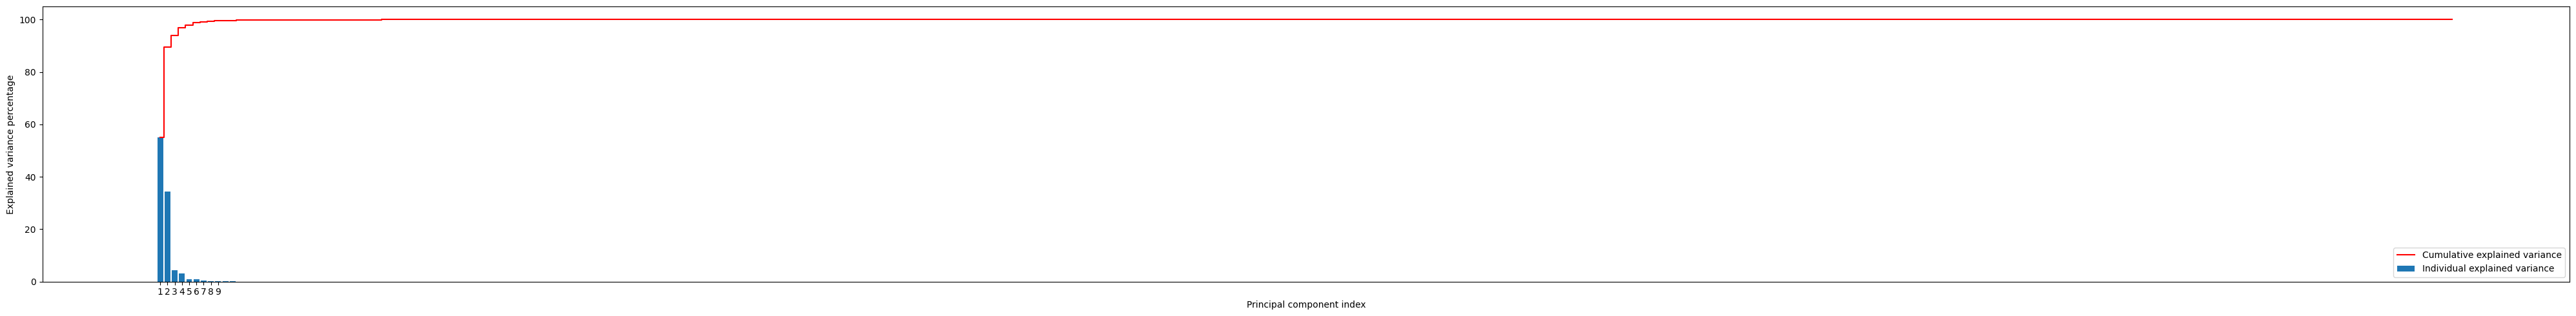

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=None)

pca.fit(numeric_df)
Kaiser = pca.explained_variance_
exp_var = pca.explained_variance_ratio_ * 100
cum_exp_var = np.cumsum(exp_var)

plt.bar(range(1, 318), exp_var, align='center',
        label='Individual explained variance')

plt.step(range(1, 318), cum_exp_var, where='mid',
         label='Cumulative explained variance', color='red')

plt.ylabel('Explained variance percentage')
plt.xlabel('Principal component index')
plt.xticks(ticks=[i for i in range(1,10)])
plt.legend(loc='best')
plt.tight_layout()

plt.savefig("Barplot.png")

In [ ]:
# Kaiser = pca.explained_variance_   
# print(Kaiser)


## after we choose the right k :


In [40]:
# k =input("inter the appropriate number of component")
from sklearn.decomposition import PCA

k=20
pca_final = PCA(n_components=0.95)
Principal_C = pca_final.fit_transform(numeric_values)
# print(Principal_C)
k = pca_final.n_components_

principalDf = pd.DataFrame(data = Principal_C
             , columns = ['Principal_C'+str(i) for i in range(1,k+1)])
principalDf.head()


,Principal_C1,Principal_C2,Principal_C3,Principal_C4,Principal_C5,Principal_C6,Principal_C7,Principal_C8,Principal_C9,Principal_C10,...,Principal_C25,Principal_C26,Principal_C27,Principal_C28,Principal_C29,Principal_C30,Principal_C31,Principal_C32,Principal_C33,Principal_C34
0,-2.089666,1.846895,-1.109346,0.775556,-0.682265,0.510369,-0.756952,1.376333,0.023856,-0.308168,...,0.031447,0.037553,-0.024317,-0.038498,0.087420,-0.143081,-0.000988,0.155571,-0.040000,-0.074996
1,-1.989226,1.600930,-0.871295,0.428945,-0.364496,0.118678,1.756514,-6.112381,1.505545,-0.602691,...,0.125571,-0.609846,-0.161437,0.638203,0.148411,-0.793713,0.533200,-1.113186,-0.637566,0.659294
2,-2.065262,1.751485,-1.011097,0.614474,-0.520423,0.316424,0.785462,-3.545305,1.153094,-0.743534,...,0.094821,-0.184605,-0.245100,0.349352,0.471582,-0.908881,-0.140639,0.018720,-0.311790,-0.114249
3,-2.100384,1.846512,-1.116153,0.783201,-0.782661,0.549270,0.037463,-1.402707,0.702959,-0.450191,...,0.055949,-0.071472,0.019806,-0.252971,-0.199417,0.709140,-0.030865,-0.028674,-0.037294,-0.018209
4,-1.998279,1.666719,-0.912659,0.526526,-0.351257,0.176940,-0.511708,1.614863,-0.437737,0.341445,...,-0.016801,-0.087867,0.151149,-0.167664,-0.052485,-0.159864,0.479732,-0.123880,-0.477159,0.333671


coveiance of the K_componeent

<Axes: >

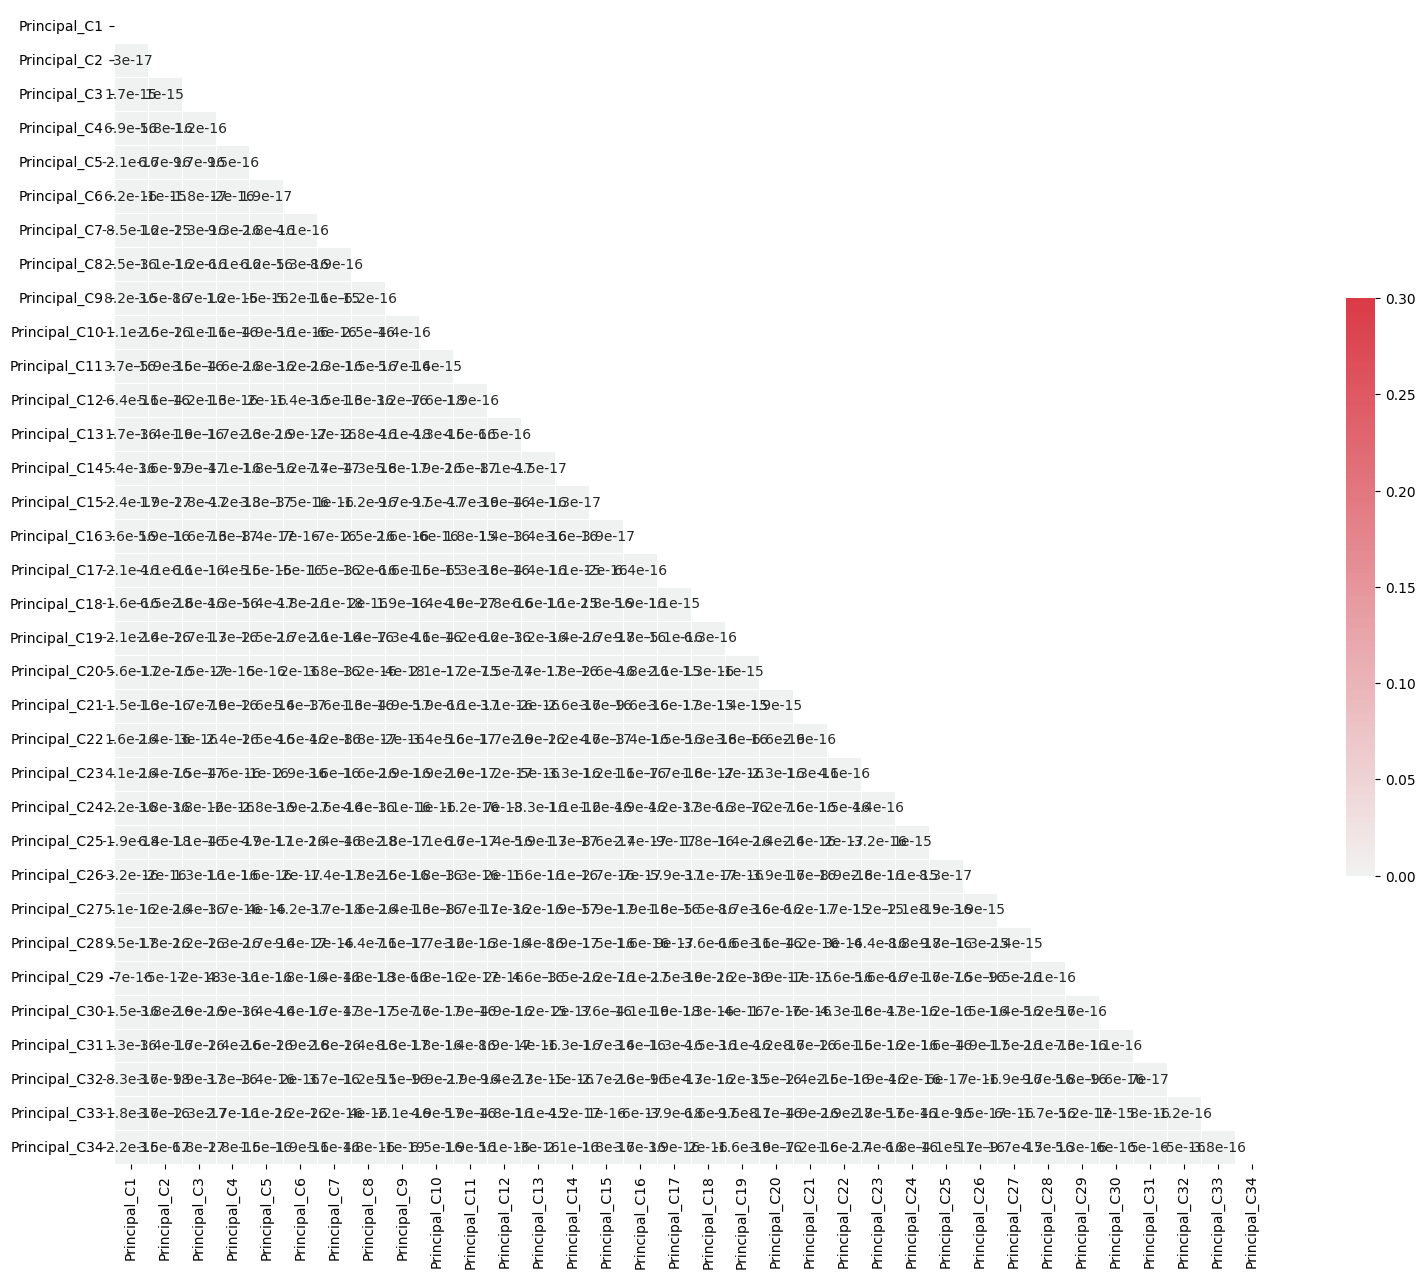

In [41]:
corr = principalDf.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool_))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(20, 15))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [42]:
Kaiser = pca_final.explained_variance_   
print(Kaiser)

[127.75189562  55.72209087  30.63833406  16.48895735  11.40013013
   8.03382139   5.78510074   5.18462854   4.65080814   3.48236031
   2.96210964   2.54475515   2.33154618   2.0902702    1.93481597
   1.74082408   1.61228353   1.44157515   1.32731518   1.26384981
   1.24003307   1.06512893   1.0414844    1.01465679   1.00077819
   0.99222975   0.98732108   0.95854304   0.91579866   0.88531827
   0.82300554   0.79719545   0.75370106   0.71565644]


## de la nouveau dataFrame :
NEw_df = du - numerical + principalDF

In [43]:
result = _dframe.drop(numeric_df.columns, axis=1)
New_DF =  result.join( principalDf,) 
New_DF.head()
New_DF['type'] =New_DF['type'].replace({'benign': 1, 'phishing': 0})


In [44]:
New_DF.to_csv('data_preprossessed.csv', columns=New_DF.columns, index=False)
